In [154]:
#| include: false
# Import libraries
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mc
import seaborn as sns
import colorsys
import psycopg2
%matplotlib inline

# Local Database Configuration:
sqluser = 'pranath'
dbname = 'mimic'
schema_name = 'mimiciii'
# Connect to MIMIC-III database:
con = psycopg2.connect(dbname=dbname, user=sqluser, password='')

## Introduction

In an [earlier article we looked at how we can extract some useful descriptive statistics from the MIMIC-III EHR (Electronic Health Record) database](2022-03-14-using-mimic3-ehr-database.html). In this article we will further explore the MIMIC-III Dataset, looking at how we examine clinical outcomes as well as extracting indivdual patient level data.

## MIMIC-III and Clinical Outcomes

Mortality is the most commonly used outcome in prediction studies in critical care, and in fact potentially across all of medicine. Since it is a strong surrogate for realness, machine learning practitioners use this signal to infer the relationship between clinical data and patient outcome. Mortality is a deceptively simple outcome to define. In fact, the nature of retrospective data often complicates matters. For example, in MIMIC database, a number of patients have two consecutive hospitalizations in which they die as organ donors. These consecutive hospitalizations are treated as distinct hospital admissions. 

However, the underlying reason is the same. Mortality is susceptible to selection bias based on the source of the information. For example, many studies report hospital mortality as it is feasible to collect this information. However, the number of deaths recorded in the hospital database might not include the number of people that have died after they have been discharged and went to the home care. This adds noise to the outcome. 

Other important factors in defining mortality as an outcome are controllable by the researcher. For example, defining mortality as death within 30 days of admission will provide a stronger signal for immediate physiological abnormality, which is likely related to the patient's admission. On the other hand, one-year mortality will emphasize chronic illness in parallel conditions. 

in this article we will see how we can extract the mortality numbers of adult patients who were admitted to the ICU and the distribution of this mortality numbers across the different ICUs in MIMIC dataset. If a patient's death was registered while the patient was in ICU, or six hours before being admitted to, or six hours after leaving the ICU, we will assume that the patient has died in the intensive care unit. 

## Extract mortality numbers

### 1. Mortality numbers in ICU across care units 

We would like to know the mortality numbers of adult patients who were admitted to the ICU, and the distribution of these mortality numbers across the different ICUs. If a patient’s death was registered while the patient was on the ICU, or 6 hours before being admitted to, or 6 hours after leaving the ICU, we assume that the patient has died on the ICU.   

The following diagram visualizes the SQL query that is needed to obtain the ICU mortality numbers. We combine the Patients and Icustays tables based on the subject identifier, and select each patient’s date of birth and date of death, and the care unit and admission time corresponding to each ICU stay. The admission time and date of death together indicate whether or not a patient died on the ICU. The age (age >= 16) is again combined from the admission time and date of birth. 

![](https://github.com/pranath/blog/raw/master/images/mimic-sql6.png "")

In [155]:

# Compose SQL query
query = """
SELECT i.first_careunit, 
round((EXTRACT(EPOCH FROM (i.intime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) as age,
CASE WHEN p.dod IS NOT NULL 
     AND p.dod >= i.intime - interval '6 hour'
     AND p.dod <= i.outtime + interval '6 hour' THEN 'Died in ICU'
     ELSE 'Not dead' END AS icu_mortality
FROM public.patients p
INNER JOIN public.icustays i ON p.subject_id = i.subject_id
WHERE round((EXTRACT(EPOCH FROM (i.intime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) >= 16;
"""
# Run query
query_output = pd.read_sql_query(query,con)
query_output.head()

,first_careunit,age,icu_mortality
0,MICU,70.6378,Not dead
1,MICU,36.1923,Died in ICU
2,MICU,87.0874,Died in ICU
3,CCU,73.6875,Not dead
4,MICU,48.9015,Died in ICU


Overall mortality - Totals
Not dead       105
Died in ICU     31
Name: icu_mortality, dtype: int64
 
Overall mortality - Percentages
Not dead       77.205882
Died in ICU    22.794118
Name: icu_mortality, dtype: float64
 
Mortality per ICU - Totals
first_careunit  icu_mortality
CCU             Died in ICU       5
                Not dead         14
CSRU            Died in ICU       1
                Not dead          5
MICU            Died in ICU      18
                Not dead         59
SICU            Died in ICU       4
                Not dead         19
TSICU           Died in ICU       3
                Not dead          8
Name: icu_mortality, dtype: int64
 
Mortality per ICU - Percentages
first_careunit  icu_mortality
CCU             Died in ICU      26.315789
                Not dead         73.684211
CSRU            Died in ICU      16.666667
                Not dead         83.333333
MICU            Died in ICU      23.376623
                Not dead         76.623377
SICU  

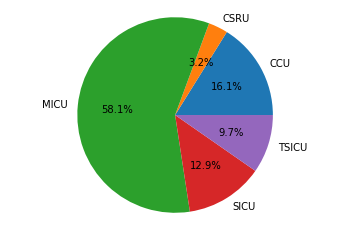

In [156]:

# Print overall mortality
print('Overall mortality - Totals')
print(query_output['icu_mortality'].value_counts())
print(' ')
print('Overall mortality - Percentages')
print(query_output['icu_mortality'].value_counts()/query_output.shape[0]*100)

# Print mortality per icu
print(' ')
print('Mortality per ICU - Totals')
result = query_output.groupby(['first_careunit','icu_mortality'])['icu_mortality'].count()
print(result)
print(' ')
print('Mortality per ICU - Percentages')
result = query_output.groupby(['first_careunit','icu_mortality'])['icu_mortality'].count() / query_output.groupby(['first_careunit'])['icu_mortality'].count() * 100
print(result)

# Print mortality percentages accross all icu
print(' ')
print('Mortality accross all ICUs')
dead_only_df = query_output[query_output['icu_mortality'] == 'Died in ICU']
icu_percentages_df = pd.DataFrame(dead_only_df.groupby(['first_careunit'])['icu_mortality'].count())
icu_percentages_df = icu_percentages_df.reset_index()
icu_percentages_df['icu_mortality'] = icu_percentages_df['icu_mortality'] / dead_only_df.shape[0] * 100
icu_percentages_df.head()

fig1, ax1 = plt.subplots()
ax1.pie(icu_percentages_df['icu_mortality'], labels=icu_percentages_df['first_careunit'], autopct='%1.1f%%')
ax1.axis('equal')  
plt.show()

### 2. Mortality numbers in hospital across care units 

We would also like to know the mortality numbers of adult patients who were admitted to hospital, and the distribution of those numbers across different ICUs. In this case, there is a variable called ‘hospital_expire_flag’ in the Admissions table that defines if a patient has died in hospital. 

The Patients and Icustays tables are combined based on the subject’s unique identifier, and the Admissions table is also joined based on the hospital admission’s identifier. We will need to select the hospital admission’s identifier, care unit, admission time and ‘hospital_expire_flag’. We also need the date of birth to obtain the age (age >= 16).  

![](https://github.com/pranath/blog/raw/master/images/mimic-sql7.png "")

In [157]:

# Compose SQL query
query = """
SELECT i.first_careunit, a.hospital_expire_flag, round((EXTRACT(EPOCH FROM (a.admittime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) as age
  FROM public.Icustays i
  INNER JOIN public.patients p ON i.subject_id = p.subject_id
  INNER JOIN public.Admissions a ON i.hadm_id = a.hadm_id
  WHERE round((EXTRACT(EPOCH FROM (a.admittime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) >= 16
"""
# Run query
query_output = pd.read_sql_query(query,con)
query_output.head()

,first_careunit,hospital_expire_flag,age
0,MICU,0,70.6378
1,MICU,1,36.1923
2,MICU,1,87.0874
3,CCU,0,73.6792
4,MICU,1,48.9014


Overall mortality - Totals
0    90
1    46
Name: hospital_expire_flag, dtype: int64
 
Overall mortality - Percentages
0    66.176471
1    33.823529
Name: hospital_expire_flag, dtype: float64
 
Mortality per ICU - Totals
first_careunit  hospital_expire_flag
CCU             0                       13
                1                        6
CSRU            0                        5
                1                        1
MICU            0                       52
                1                       25
SICU            0                       16
                1                        7
TSICU           0                        4
                1                        7
Name: hospital_expire_flag, dtype: int64
 
Mortality per ICU - Percentages
first_careunit  hospital_expire_flag
CCU             0                       68.421053
                1                       31.578947
CSRU            0                       83.333333
                1                       16.666667
M

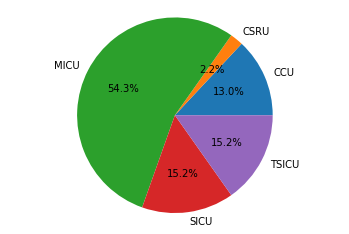

In [158]:

# Print overall mortality
print('Overall mortality - Totals')
print(query_output['hospital_expire_flag'].value_counts())
print(' ')
print('Overall mortality - Percentages')
print(query_output['hospital_expire_flag'].value_counts()/query_output.shape[0]*100)

# Print mortality per icu
print(' ')
print('Mortality per ICU - Totals')
result = query_output.groupby(['first_careunit','hospital_expire_flag'])['hospital_expire_flag'].count()
print(result)
print(' ')
print('Mortality per ICU - Percentages')
result = query_output.groupby(['first_careunit','hospital_expire_flag'])['hospital_expire_flag'].count() / query_output.groupby(['first_careunit'])['hospital_expire_flag'].count() * 100
print(result)

# Print mortality percentages accross all icu
print(' ')
print('Mortality accross all ICUs')
dead_only_df = query_output[query_output['hospital_expire_flag'] == 1]
icu_percentages_df = pd.DataFrame(dead_only_df.groupby(['first_careunit'])['hospital_expire_flag'].count())
icu_percentages_df = icu_percentages_df.reset_index()
icu_percentages_df['hospital_expire_flag'] = icu_percentages_df['hospital_expire_flag'] / dead_only_df.shape[0] * 100
icu_percentages_df.head()

fig1, ax1 = plt.subplots()
ax1.pie(icu_percentages_df['hospital_expire_flag'], labels=icu_percentages_df['first_careunit'], autopct='%1.1f%%')
ax1.axis('equal')  
plt.show()

## Extract length of stay numbers

### 1. Length of stay on the ICU across care units 
We would like to know how many days each patient has to stay on the ICU. We want to know the median, lower quantile and upper quantile for the length of stay, and also these values for each different ICU. As for all queries, we only select adult patients (age >= 16). 

The length of stay on the ICU can be found in the Icustays table.  We also need the corresponding care unit and time of admission of each ICU admission. To get the date of birth for each patient (and hence the age, computed from the admission time and date of birth), we combine the Icustays and Patients tables. 

![](https://github.com/pranath/blog/raw/master/images/mimic-sql8.png "")

In [159]:

# Compose SQL query
query = """
SELECT i.first_careunit, i.los, round((EXTRACT(EPOCH FROM (i.intime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) as age
  FROM public.Icustays i
  INNER JOIN public.patients p ON i.subject_id = p.subject_id
  WHERE round((EXTRACT(EPOCH FROM (i.intime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) >= 16
"""
# Run query
query_output = pd.read_sql_query(query,con)
query_output.head()

,first_careunit,los,age
0,MICU,1.6325,70.6378
1,MICU,13.8507,36.1923
2,MICU,2.6499,87.0874
3,CCU,2.1436,73.6875
4,MICU,1.2938,48.9015


 
Descriptive statistics for MICU by los
count    77.000000
mean      3.955345
std       5.193230
min       0.190400
25%       1.135800
50%       1.925200
75%       4.101400
max      31.123500
Name: los, dtype: float64
 
Descriptive statistics for CCU by los
count    19.000000
mean      5.753900
std       7.024671
min       0.879900
25%       1.862600
50%       2.883300
75%       4.242450
max      24.996800
Name: los, dtype: float64
 
Descriptive statistics for SICU by los
count    23.000000
mean      5.668461
std       8.751901
min       0.743700
25%       1.910350
50%       2.405600
75%       5.022700
max      35.406500
Name: los, dtype: float64
 
Descriptive statistics for CSRU by los
count    6.000000
mean     3.631350
std      3.199466
min      0.901700
25%      1.464500
50%      2.084000
75%      6.010175
max      8.141500
Name: los, dtype: float64
 
Descriptive statistics for TSICU by los
count    11.000000
mean      3.589609
std       6.422052
min       0.105900
25%       0.647

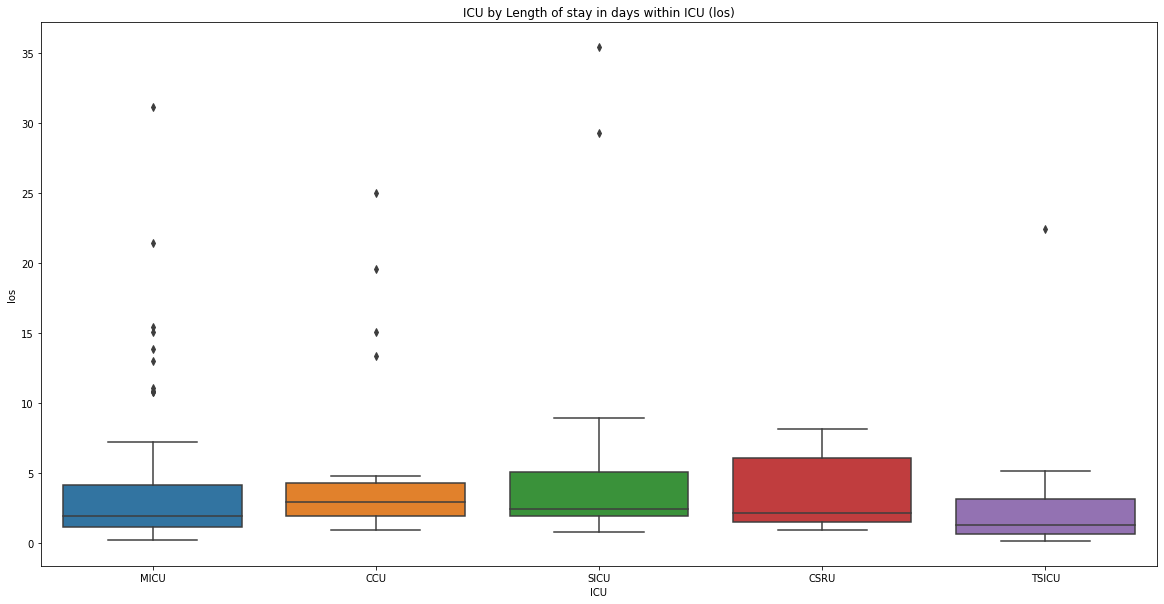

In [160]:

# Define function for descriptive stats 5 number summary for a field per icu
def icu_descriptive_stats(field, df, boxplot_title):
    
    # Get list of ICUs
    icu_list = df['first_careunit'].unique()
    # Plot descriptive stats for each ICU
    for icu in icu_list:
        print(' ')
        print('Descriptive statistics for ' + str(icu) + ' by ' + field)
        icu_df = df[df['first_careunit'] == icu]
        print(icu_df[field].describe())   
       
    # Plot box plot of ICU by field
    plt.figure(figsize=(20,10))
    sns.boxplot(data=df, x='first_careunit', y=field)
    plt.xlabel('ICU')
    plt.title(boxplot_title)   

# 5 number summary all ICUs for los (length of stay within icu)
icu_descriptive_stats('los', query_output, 'ICU by Length of stay in days within ICU (los)')

### 2. Length of stay in hospital across care units 
This query is almost similar to the previous one, but now we are interested in the length of stay (in days) of adult patients in hospital instead of on the ICUs. We are also interested to know the distribution of those values across ICUs.  

We combine the Patients and Icustays tables based on the subject identifier, and the Admissions table based on the unique hospital admission identifier. This time, we use date of birth and time of admission to the hospital to compute age, and filter on it using age >= 16. There is no variable for length of stay in hospital, but we can compute it by subtracting the discharge time from the admission time. Moreover, we will need the ICU the patient is admitted to. The unique hospital admission identifier is used to make sure each hospital admission corresponds to only one ICU (we use the hospital admission identifier to remove duplicates). 

![](https://github.com/pranath/blog/raw/master/images/mimic-sql9.png "")

In [161]:

# Compose SQL query
query = """  
SELECT i.first_careunit, a.hadm_id, a.dischtime, a.admittime, round((EXTRACT(EPOCH FROM (a.admittime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) as age, 
round((EXTRACT(EPOCH FROM (a.dischtime-a.admittime))/60/60/24) :: NUMERIC, 4) as hospital_los
  FROM public.Icustays i
  INNER JOIN public.patients p ON i.subject_id = p.subject_id
  INNER JOIN public.Admissions a ON i.hadm_id = a.hadm_id
  WHERE round((EXTRACT(EPOCH FROM (a.admittime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) >= 16
"""
# Run query
query_output = pd.read_sql_query(query,con)
# Drop duplicates based on unique hospital admission id
query_output = query_output.drop_duplicates(['hadm_id'])
# Remove outliers
query_output = query_output[query_output['hospital_los'] < 100]
query_output.head()

,first_careunit,hadm_id,dischtime,admittime,age,hospital_los
0,MICU,142345,2164-11-01 17:15:00,2164-10-23 21:09:00,70.6378,8.8375
1,MICU,105331,2126-08-28 18:59:00,2126-08-14 22:32:00,36.1923,13.8521
2,MICU,165520,2125-10-07 15:13:00,2125-10-04 23:36:00,87.0874,2.6507
3,CCU,199207,2149-06-03 18:42:00,2149-05-26 17:19:00,73.6792,8.0576
4,MICU,177759,2163-05-15 12:00:00,2163-05-14 20:43:00,48.9014,0.6368


 
Descriptive statistics for MICU by hospital_los
count    73.000000
mean      8.073463
std       6.847850
min       0.144400
25%       3.903500
50%       5.988200
75%       9.797900
max      36.011800
Name: hospital_los, dtype: float64
 
Descriptive statistics for CCU by hospital_los
count    16.000000
mean      8.274125
std       6.723373
min       0.959000
25%       2.949825
50%       6.618750
75%      11.067150
max      24.997900
Name: hospital_los, dtype: float64
 
Descriptive statistics for SICU by hospital_los
count    22.000000
mean     11.616982
std      10.893085
min       2.107600
25%       3.697600
50%       8.138900
75%      13.385575
max      39.697200
Name: hospital_los, dtype: float64
 
Descriptive statistics for CSRU by hospital_los
count     6.000000
mean      7.588333
std       4.976149
min       0.770800
25%       4.284925
50%       8.046200
75%      12.027300
max      12.281300
Name: hospital_los, dtype: float64
 
Descriptive statistics for TSICU by hospital_los
co

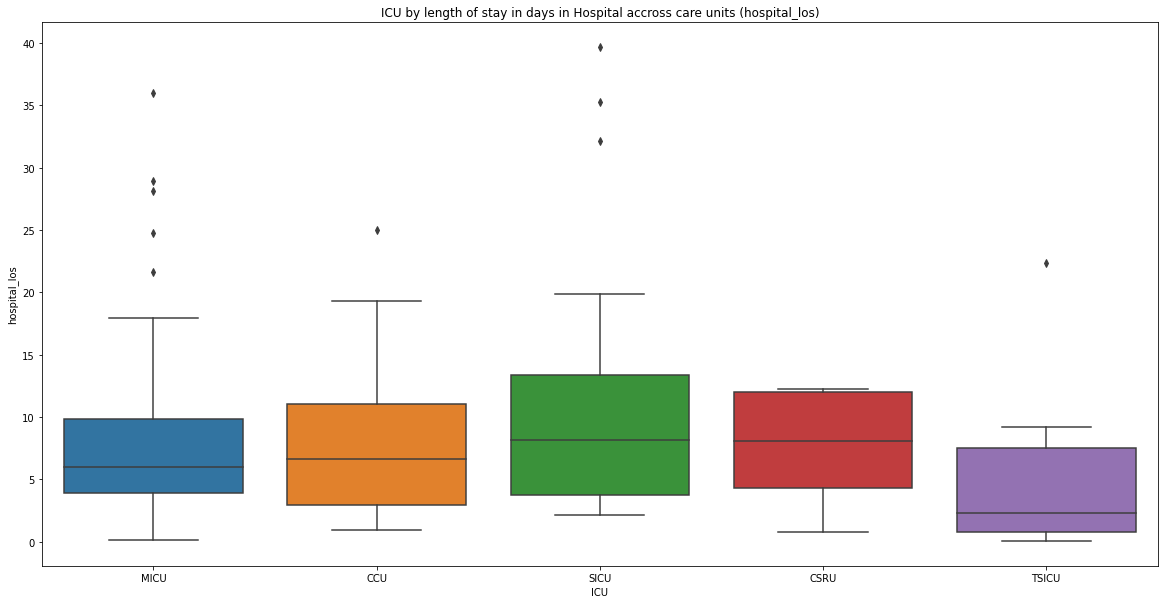

In [162]:

# 5 number summary all ICUs for los (length of stay in hospital)
icu_descriptive_stats('hospital_los', query_output, 'ICU by length of stay in days in Hospital accross care units (hospital_los)')

## Extracting Vital Signs for a single patient from MIMIC-III

It is useful to be able to extract vital signs and medication of a single patient that was admitted to an intensive care unit, for example we might need to extract clinical variables across patients such as lab exams, sign and wave forms, as well as doctor reports and prescriptions. For thsi example we will pick randomly an ICU stay identifier and the corresponding subject identifier. We will then look the data related to this patient and this ICU stay admission. 

### 1. Hospital admission of a single patient

First of all we would like to get the hospital admission of a single patient during a single ICU stay. We want to have table with the patient’s unique subject identifier, hospital identifier, the admission type, the diagnosis, the ICU stay identifier, the first and last care unit that he/she was admitted to, and the time of admission to the ICU. We also want to choose for our example a patient who died in-hospital.

We will need the Admissions, Patients, and Icustays tables to collect the information that we need. We join the three tables, and find only the patients who have died i.e. where hospital_expire_flag is 1.

In [163]:

# Load admissions
query = """
SELECT ad.subject_id, ad.hadm_id, ad.admission_type, ad.diagnosis, 
    ic.icustay_id, ic.first_careunit, ic.last_careunit, ic.intime as icu_intime, 
    ad.hospital_expire_flag, pa.expire_flag
FROM admissions ad
INNER JOIN icustays ic
ON ad.subject_id = ic.subject_id
INNER JOIN patients pa
ON ad.subject_id = pa.subject_id
WHERE ad.hospital_expire_flag = 1 
ORDER BY ic.intime
"""

admissions = pd.read_sql_query(query,con)

# Show the (first few) rows of admissions:
admissions.head()

,subject_id,hadm_id,admission_type,diagnosis,icustay_id,first_careunit,last_careunit,icu_intime,hospital_expire_flag,expire_flag
0,10102,164869,EMERGENCY,CHRONIC MYELOGENOUS LEUKEMIA;TRANSFUSION REACTION,223870,MICU,MICU,2105-06-08 20:06:06,1,1
1,10076,198503,EMERGENCY,LUNG CANCER;SHORTNESS OF BREATH,201006,MICU,MICU,2107-03-24 04:06:14,1,1
2,43746,167181,EMERGENCY,METASTIC MELANOMA;ANEMIA,289236,SICU,SICU,2111-01-07 16:36:48,1,1
3,43746,167181,EMERGENCY,METASTIC MELANOMA;ANEMIA,224458,SICU,SICU,2111-01-12 15:26:49,1,1
4,42066,171628,EMERGENCY,TRACHEAL STENOSIS,244243,TSICU,TSICU,2112-02-04 14:49:33,1,1


In [164]:
# Select a single ICU stay. We will select one
icustay_id = admissions['icustay_id'].iloc[2]
icustay_id

289236

### 2. All charted events of a single patient

Charted events contain information such as heart rate and respiratory rate of a patient. We would like all charted events of a single patient, along with the time of the charted events, the time between admission to the ICU and the charted event, the label corresponding to the event, and the value and measurement unit of the event. 

We need the Chartevents and Icustays tables to get the charted events for a single patient on the ICU. We also join the D_items table to get the label of a charted event. Moreover, we filter on a specific ICU stay ID to get the data for a single patient and single ICU admission.  

In [165]:

# Load chart events
query = """
SELECT  ic.icustay_id, ce.charttime, ce.charttime - ic.intime AS icutime, di.label, ce.value, ce.valuenum, ce.valueuom
FROM Chartevents ce
INNER JOIN D_items as di
ON ce.itemid = di.itemid
INNER JOIN icustays ic
ON ce.icustay_id = ic.icustay_id
WHERE ic.icustay_id = """ + str(icustay_id) + """ 
ORDER BY ce.charttime
"""

chartevents = pd.read_sql_query(query,con)

# Show the (first few) rows of admissions:
chartevents.head()

,icustay_id,charttime,icutime,label,value,valuenum,valueuom
0,289236,2111-01-07 15:00:00,-1 days +22:23:12,Head of Bed,30 Degrees,NaN,None
1,289236,2111-01-07 15:00:00,-1 days +22:23:12,Activity,Bedrest,NaN,None
2,289236,2111-01-07 15:00:00,-1 days +22:23:12,Turn,Side to Side,NaN,None
3,289236,2111-01-07 15:00:00,-1 days +22:23:12,Assistance Device,2 Person Assist,NaN,None
4,289236,2111-01-07 15:00:00,-1 days +22:23:12,Position,Left Side,NaN,None


### 3. All outputs recorded during an ICU stay of a single patient 

Output events are also recorded during an ICU stay. We would like to collect the time of the output event, the time since admission to the ICU, the label of the event, the value and the corresponding measurement event. 

The query is similar to the previous query, however, this time we will need the Outputevents table and combine it with the Icustays and D_items tables. We again filter on a specific ICU stay ID to get the data for a single patient and a single ICU stay. The charted time and time of ICU admission are combined to get the time of the output event since the time of ICU admission. 

In [166]:

# Load Output events
query = """
SELECT  ic.icustay_id, oe.charttime, oe.charttime - ic.intime AS icutime, di.label, oe.value, oe.valueuom
FROM Outputevents oe
INNER JOIN D_items as di
ON oe.itemid = di.itemid
INNER JOIN icustays ic
ON oe.icustay_id = ic.icustay_id
WHERE ic.icustay_id = """ + str(icustay_id) + """ 
ORDER BY oe.charttime
"""

outputevents = pd.read_sql_query(query,con)

# Show the (first few) rows of admissions:
outputevents.head()

,icustay_id,charttime,icutime,label,value,valueuom
0,289236,2111-01-07 17:00:00,0 days 00:23:12,Pre-Admission,194.0,mL
1,289236,2111-01-07 17:30:00,0 days 00:53:12,Foley,45.0,mL
2,289236,2111-01-07 18:28:00,0 days 01:51:12,Pre-Admission,194.0,mL
3,289236,2111-01-07 18:35:00,0 days 01:58:12,Foley,20.0,mL
4,289236,2111-01-07 19:00:00,0 days 02:23:12,Foley,30.0,mL


### 4. All inputs recorded during an ICU stay of a single patient

Input events could be, for example, the use of medication. We would like to collect all input events for a single patient and ICU stay. We are also interested in the corresponding start and end times of the events, those times relative to ICU admission time, the label of the input event, the amount and measurement unit, and how often the input event (medication) is administered.

The input events can be found in the Inputevents_mv table. We join this table with the Icustays and D_items tables to get the time of admission to the ICU and label corresponding to the input event. Again, we filter on a specific ICU stay ID to get the data for a single patient and a single ICU stay. We also filter out rewritten input events.

In [176]:

# Load Input events
query = """
SELECT  ic.icustay_id, ie.starttime, ie.endtime, ie.starttime - ic.intime as icustarttime, ie.endtime - ic.intime as icuendtime, di.label, ie.amount, 
    ie.amountuom, ie.rate, ie.rateuom, ie.statusdescription
FROM inputevents_mv ie
INNER JOIN icustays ic
ON ie.icustay_id = ic.icustay_id
INNER JOIN D_items as di
ON ie.itemid = di.itemid
WHERE ic.icustay_id = """ + str(icustay_id) + """ 
AND lower(ie.statusdescription) != 'rewritten'
ORDER BY ie.starttime
"""

inputevents = pd.read_sql_query(query,con)

# Show the (first few) rows of admissions:
inputevents.head()

,icustay_id,starttime,endtime,icustarttime,icuendtime,label,amount,amountuom,rate,rateuom,statusdescription
0,289236,2111-01-07 16:45:00,2111-01-07 16:46:00,0 days 00:08:12,0 days 00:09:12,Pre-Admission Intake,3400.000000,ml,NaN,None,FinishedRunning
1,289236,2111-01-07 17:00:00,2111-01-08 00:56:00,0 days 00:23:12,0 days 08:19:12,D5 1/2NS,991.699971,ml,125.004198,mL/hour,FinishedRunning
2,289236,2111-01-07 18:00:00,2111-01-07 18:01:00,0 days 01:23:12,0 days 01:24:12,NaCl 0.9%,500.000000,ml,NaN,None,FinishedRunning
3,289236,2111-01-07 18:30:00,2111-01-07 18:31:00,0 days 01:53:12,0 days 01:54:12,Morphine Sulfate,2.000000,mg,NaN,None,FinishedRunning
4,289236,2111-01-07 20:13:00,2111-01-07 20:43:00,0 days 03:36:12,0 days 04:06:12,Albumin 25%,49.999998,ml,99.999996,mL/hour,FinishedRunning


### 5. All lab events recorded during an ICU stay of a single patient
Examples of lab events could be the number of red blood cells in the body, or magnesium levels. We want to get all lab events for a single patient and a single ICU stay. We also are interested to see the time of these lab events, time since ICU admission, label, value, and measurement unit.

Lab events are in the Labevents table. We join the Icustays and D_labitems tables, and filter out any lab events that were recorded before or after the patient was at the ICU. 

In [182]:

# Load lab events
query = """
SELECT  ic.subject_id, ic.icustay_id, le.charttime, le.charttime - ic.intime as icutime, di.label, le.value, le.valuenum, le.valueuom 
FROM labevents le
INNER JOIN icustays ic
    ON le.subject_id = ic.subject_id
    AND le.charttime >= ic.intime
    AND le.charttime <= ic.outtime
INNER JOIN D_labitems as di
    ON le.itemid = di.itemid
WHERE ic.icustay_id = """ + str(icustay_id) + """ 
ORDER BY le.charttime
"""

labevents = pd.read_sql_query(query,con)

# Show the (first few) rows of admissions:
labevents.head()

,subject_id,icustay_id,charttime,icutime,label,value,valuenum,valueuom
0,43746,289236,2111-01-07 17:23:00,0 days 00:46:12,Specific Gravity,1.024,1.024,
1,43746,289236,2111-01-07 17:23:00,0 days 00:46:12,GR HOLD,HOLD,NaN,None
2,43746,289236,2111-01-07 17:23:00,0 days 00:46:12,Creatinine,1.9,1.900,mg/dL
3,43746,289236,2111-01-07 17:23:00,0 days 00:46:12,Glucose,NEG,NaN,mg/dL
4,43746,289236,2111-01-07 17:23:00,0 days 00:46:12,Glucose,139,139.000,mg/dL
